In [8]:
import os
import time
from IPython.display import clear_output
from collections import defaultdict, Counter
import math
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
# must have n lines
# read in contents of single file as dictionary
# load all files as dict of dicts
# calculate tf-idf for each word
# get top n 

#sparse matrix representation

In [5]:
## Function to extract top N for specific sub
## Function to get idf for specific word

## Build the word count dictionary

In [12]:
def build_word_count_dictionary(date):
    '''
    Provide a date in YYYY-MM format, you'll have to update it to match your src dir
    '''
    src_dir = f'/Users/choldawa/Documents/Projects/RedditCorpus/word_count/RC_{date}'

    tick = time.time()

    d = {}
    problem_subs = []
    cnt = 0
    for file in os.listdir(src_dir):
        path = src_dir+"/"+file
        with open(path) as f:
            filename = os.path.basename(file).split("_")[2].split(".")[0]
            clear_output(wait=True)
            print(f"working on: {filename}")
            tock = time.time()
            print(f"Time elapsed: {tock - tick} seconds")
            sub_d = {}
            num_lines = sum(1 for line in open(path)) #must have at least 100 unique words
            if num_lines > 100:
                for line in f:
                    try:
                        (val, key) = line.strip().split() #invert the order 
                        if not any(map(str.isdigit, key)) and int(val)>1: # each word must occur more than once
                             if key not in stop_words: #check if stopword   
                                sub_d[key] = int(val)
                    except:
                        problem_subs.append(filename)
                d[filename] = sub_d
    end = time.time()
    print(f"Total subreddits: {len(d)}, Time elapsed: {end - tick} seconds for {date}") 
    
    return d

### Create the dictionary (this can take a couple of minutes depending on data size)

In [11]:
d = build_word_count_dictionary('2012-12')

working on: CrowdfundedBoardgames
Time elapsed: 96.41405010223389 seconds
Total subreddits: 11427,             Time elapsed: 96.4146819114685 seconds for 2012-12


In [58]:
print(f"""Let's see a list of subreddit names: 
        {list(d.keys())[:5]}
        """)


subreddit = 'politics'
print(f"Here are some example common words in r/{subreddit}:")
print(list(d[subreddit].items())[:5])

Let's see a list of subreddit names: 
        ['terrariums', 'oklahoma', 'hackerspaces', 'TheContinuum', 'GothicMetal']
        
Here are some example common words in r/politics:
[('people', 116175), ('would', 84858), ('dont', 77698), ('like', 70930), ('one', 56556)]


## Get the count of subs that contain a target word

In [15]:
def get_word_sub_count(word, month_dictionary):
    '''
    get the count subs in a given month that contain a gieven word
    requires a word, and a dictionary for that month
    '''
    N = len(month_dictionary)
    
    cnt = 0
    for s in month_dictionary:
        if word in month_dictionary[s]: #count of subs where w appears
            cnt += 1
    return cnt

In [16]:
get_word_sub_count('bitcoin', d)

113

## Get tfi-idf transformer and matrix using sklearn

In [20]:
def build_vectorizer_tfidf_matrix(d):
    """
    Provide the word count dictionary
    Will output two objects: 
        - a dictVecotrizer which will be used to access the column names (words)
        - the tfidf transformed matrix (sparse matrix) to get tf-idf values
    """
    print("Building tfidf...")
    dv = DictVectorizer()
    #D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}] #EXAMPLE FORMAT
    X = dv.fit_transform(list(d.values()))
    tv = TfidfTransformer()
    tfidf = tv.fit_transform(X)
    return dv, tfidf
#     print(tfidf.toarray())

In [19]:
#Run vectorizer, this can take some time
tfidf = build_vectorizer_tfidf_matrix(d)
print(tfidf[1].toarray().shape)

'staircases'

In [29]:
def get_top_k_tfidf(k, d, tfidf, subreddit):
    '''
    Get the top tfidf embeddings for a given subreddit
    Takes: k (top k tfidf words), 
            month dictionary,
            the tfidf matrix, 
            and target subreddit
    '''
    index = list(d.keys()).index(subreddit)
    # Take the indices of the largest k elements from each row
    top_k_inds = np.argsort(tfidf[1][index,:].toarray())[:, -1:-k - 1:-1]
#     # Take the values at those indices
#     top_k = np.take_along_axis(tfidf.toarray(), top_k_inds, axis=-1)
#     top_k_pairs = np.stack((top_k_inds, top_k), axis=2)
    
    #return list of top words
    top_tfidf_words = []
    for ind in top_k_inds[0]:
        top_tfidf_words.append(tfidf[0].get_feature_names()[ind])
    return top_tfidf_words

In [31]:
k, subreddit = 5, 'crazystairs'

print(f'The top {k} words for r/{subreddit} are:')
get_top_k_tfidf(k, d, tfidf, subreddit)

The top 5 words for r/crazystairs are:


['stairs', 'nsfw', 'xpost', 'staircase', 'staircases']

## Get count of subs containing given word over time

In [34]:
#Get count of subs containing given word over time
date_list = ['2008-12', '2012-12']
dict_list = []
for date in date_list:
    dict_list.append(build_word_count_dictionary(date))


working on: CrowdfundedBoardgames
Time elapsed: 93.08437180519104 seconds
Total subreddits: 11427, Time elapsed: 93.08520984649658 seconds for 2012-12


[5, 56]


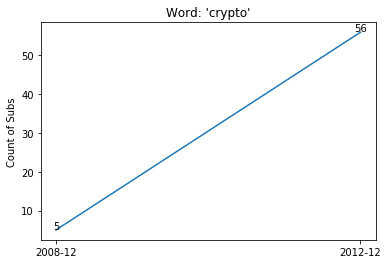

In [48]:
word = 'crypto'
sub_count_list = []

for d in dict_list:
    sub_count_list.append(get_word_sub_count(word, d))
print(sub_count_list)
plt.plot(date_list, sub_count_list)
for x,y in zip(date_list,sub_count_list):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,1), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.title(f"Word: '{word}'")
plt.ylabel("Count of Subs")
plt.show()

In [49]:
sub_count_list

[5, 56]

### Plot histogram of word counts

In [ ]:
print(f"We have {len(df)} unique words and {len(d)} unique subreddits")
logD = {k:np.log10(v) for k, v in df.items()}
plt.hist(logD.values(), bins = 25)
plt.xlabel("Log10 num of subreddits")
plt.ylabel("Count of words")
plt.plot()

### Plotting sorted dict

In [ ]:
sub_reddit = 'theoffice' # theoffice
topN = 6
x = list(dict(sorted(sub_dict[sub_reddit].items(), 
                           key=lambda item: item[1], reverse = True)
                    [:topN]).keys())
y = list(dict(sorted(sub_dict[sub_reddit].items(), 
                           key=lambda item: item[1], reverse = True)
                    [:topN]).values())


plt.bar(x,y, align='center')
plt.xticks(rotation=70)
plt.title(sub_reddit)
plt.show()